In [1]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
%conda install pytorch torchvision -c pytorch

Channels:
 - pytorch
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [6]:
from torchvision import datasets, transforms

# Define the path to the train dataset
train_path = "/Users/user/Documents/I5/AI/Final_AI_Project/split_dataset/train"

# Define the transformations used for the training dataset
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the train dataset
train_dataset = datasets.ImageFolder(train_path, transform=data_transforms)

# Access the class names
num_classes = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}")


Classes: ['airplane', 'bicycles', 'cars', 'motorbikes', 'ships']


In [9]:
import torch
from torchvision import models
import torch.nn as nn

# Reinitialize the model architecture
pretrained_model = models.resnet50(pretrained=False)  # Use pretrained=False to avoid downloading weights
num_classes = len(train_dataset.classes)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# Load the state dictionary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.load_state_dict(torch.load('resnet50_vehicle_classifier1.pth', map_location=device))
pretrained_model = pretrained_model.to(device)

print("Model loaded successfully.")


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully.


/var/folders/rh/pb3vmf1d43d_z4xt5jr0bmwr0000gn/T/ipykernel_48563/2193894615.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load(

In [10]:
import torch
from torchvision import transforms
from PIL import Image

def predict_image(model, image_path, class_names):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)
        return class_names[predicted.item()]


In [11]:
import os
test_image_path = "/Users/user/Documents/I5/AI/Final_AI_Project/split_dataset/test/airplane/1VI1TSY50SEQ.jpg"
if os.path.exists(test_image_path):
    predicted_class = predict_image(pretrained_model, test_image_path, train_dataset.classes)
    print(f"Predicted class: {predicted_class}")
else:
    print(f"Test image path does not exist: {test_image_path}")


Predicted class: airplane


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

# Define the path to the test dataset
test_path = "/Users/user/Documents/I5/AI/Final_AI_Project/split_dataset/test"

# Load the test dataset
test_dataset = datasets.ImageFolder(test_path, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(pretrained_model, test_loader, device)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9780
Precision: 0.9784
Recall: 0.9780
F1 Score: 0.9780


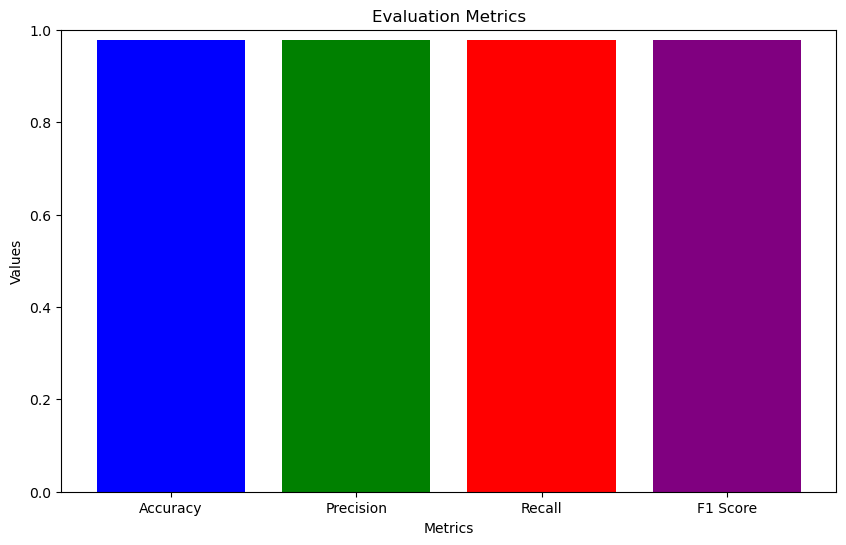

In [13]:
import numpy as np

import matplotlib.pyplot as plt

# Define the metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
plt.show()

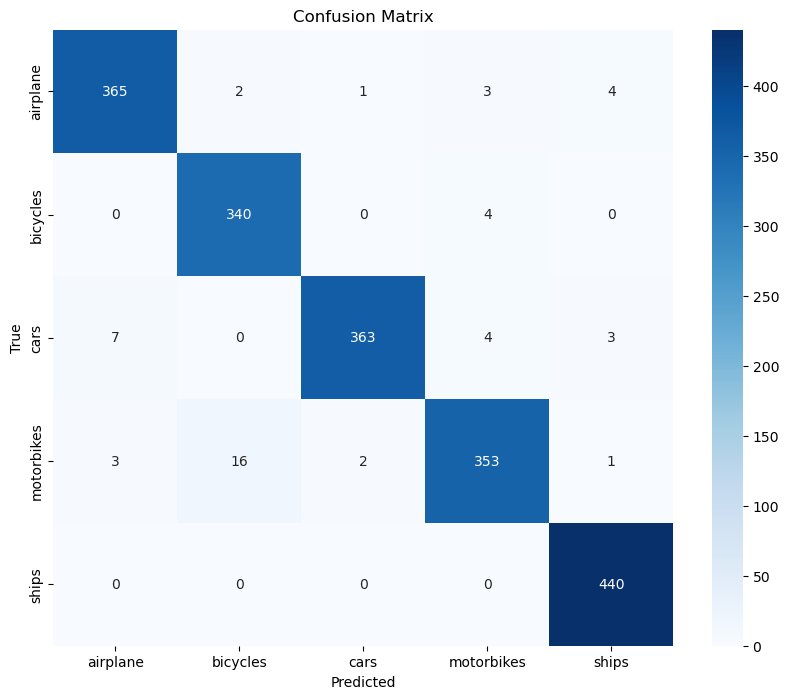

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels and predicted labels
all_preds = []
all_labels = []

pretrained_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

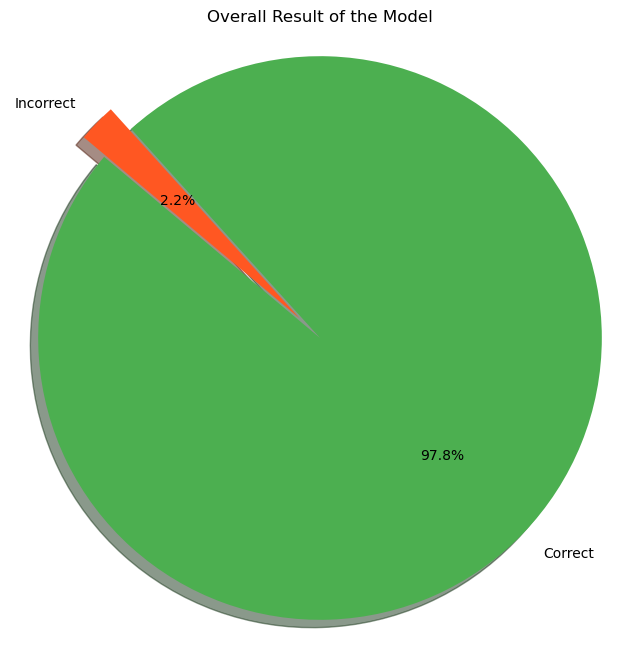

Overall Accuracy: 97.80%


In [18]:
import matplotlib.pyplot as plt

# Calculate the number of correct and incorrect predictions
total_predictions = len(test_dataset)
correct_predictions = int(accuracy * total_predictions)
incorrect_predictions = total_predictions - correct_predictions

# Data for the pie chart
labels = ['Correct', 'Incorrect']
sizes = [correct_predictions, incorrect_predictions]
colors = ['#4CAF50', '#FF5722']
explode = (0.1, 0)  # explode the 1st slice (i.e. 'Correct')

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=140)
plt.title('Overall Result of the Model')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Note: you may need to restart the kernel to use updated packages.


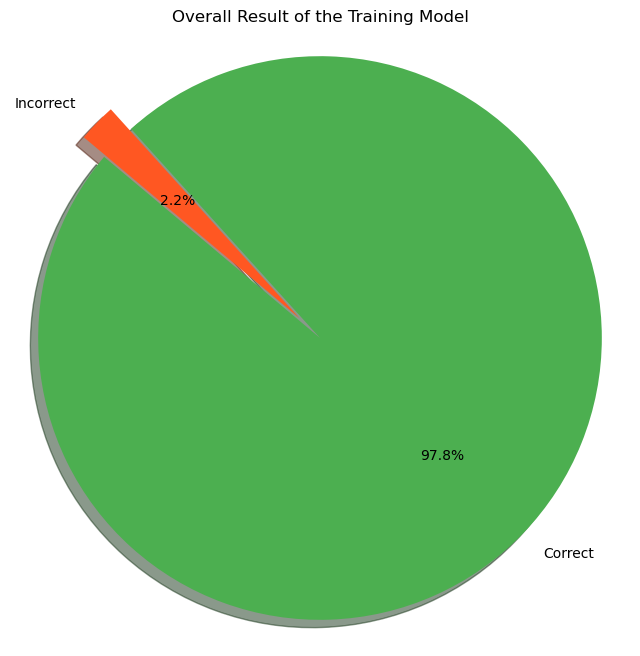

In [20]:
%pip install matplotlib
import matplotlib.pyplot as plt

# Use the correct and total values from the evaluation
correct_predictions = correct_predictions
incorrect_predictions = total_predictions - correct_predictions

# Data for the pie chart
labels = ['Correct', 'Incorrect']
sizes = [correct_predictions, incorrect_predictions]
colors = ['#4CAF50', '#FF5722']
explode = (0.1, 0)  # explode the 1st slice (i.e. 'Correct')

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
    shadow=True, startangle=140)
plt.title('Overall Result of the Training Model')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()